## 星巴克促销活动 A/B 测试
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### 背景信息

此练习将提供一个数据集，星巴克原先使用该数据集作为面试题。这道练习的数据包含 120,000 个数据点，按照 2:1 的比例划分为训练文件和测试文件。数据模拟的实验测试了一项广告宣传活动，看看该宣传活动能否吸引更多客户购买定价为 10 美元的特定产品。由于公司分发每份宣传资料的成本为 0.15 美元，所以宣传资料最好仅面向最相关的人群。每个数据点都有一列表示是否向某个人发送了产品宣传资料，另一列表示此人最终是否购买了该产品。每个人还有另外 7 个相关特征，表示为 V1-V7。

#### 优化策略

你的任务是通过训练数据了解 V1-V7 存在什么规律表明应该向用户分发宣传资料。具体而言，你的目标是最大化以下指标：

* **增量响应率 (IRR)** 

IRR 表示与没有收到宣传资料相比，因为推广活动而购买产品的客户增加了多少。从数学角度来说，IRR 等于推广小组的购买者人数与购买者小组客户总数的比例 (_treatment_) 减去非推广小组的购买者人数与非推广小组的客户总数的比例 (_control_)。

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **净增量收入 (NIR)**

NIR 表示分发宣传资料后获得（丢失）了多少收入。从数学角度来讲，NIR 等于收到宣传资料的购买者总人数的 10 倍减去分发的宣传资料份数的 0.15 倍，再减去没有收到宣传资料的购买者人数的 10 倍。

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

要详细了解星巴克提供给应聘者的数据集，请参阅[此处的说明](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM)。

下面是训练数据。研究数据和不同的优化策略。

#### 如何测试你的策略？

如果你想到了优化策略，请完成要传递给 `test_results` 函数的 `promotion_strategy` 函数。  
根据以往的数据，我们知道有四种可能的结果：

实际推广客户与预测推广客户表格：  

<table>
<tr><th></th><th colspan = '2'>实际</th></tr>
<tr><th>预测</th><th>是</th><th>否</th></tr>
<tr><th>是</th><td>I</td><td>II</td></tr>
<tr><th>否</th><td>III</td><td>IV</td></tr>
</table>

我们仅针对预测应该包含推广活动的个人比较了指标，即第一象限和第二象限。由于收到宣传资料的第一组客户（在训练集中）是随机收到的，因此第一象限和第二象限的参与者人数应该大致相同。  

比较第一象限与第二象限可以知道宣传策略未来效果如何。 

首先阅读以下数据。看看每个变量或变量组合与推广活动对购买率有何影响。你想到谁应该接收宣传资料的策略后，请使用在最后的 `test_results` 函数中使用的测试数据集测试你的策略。

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. 数据研究

In [2]:
# load in the data
train_data = pd.read_csv('./data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
# check for data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
# check dataset
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
# check for null value
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [6]:
# load in the data
test_data = pd.read_csv('./data/Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41650 entries, 0 to 41649
Data columns (total 10 columns):
ID           41650 non-null int64
Promotion    41650 non-null object
purchase     41650 non-null int64
V1           41650 non-null int64
V2           41650 non-null float64
V3           41650 non-null float64
V4           41650 non-null int64
V5           41650 non-null int64
V6           41650 non-null int64
V7           41650 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 3.2+ MB


In [8]:
test_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000
mean,63339.155774,0.011525,1.493469,29.986774,-0.000387,1.680792,2.319256,2.505642,1.704010
std,36441.521173,0.106734,0.864138,4.981025,0.999026,0.466175,0.845162,1.119879,0.456492
min,2.000000,0.000000,0.000000,9.202546,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31688.500000,0.000000,1.000000,26.606134,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,63601.000000,0.000000,1.000000,29.979507,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,95017.250000,0.000000,2.000000,33.369989,0.826206,2.000000,3.000000,4.000000,2.000000
max,126178.000000,1.000000,3.000000,55.107509,1.691984,2.000000,4.000000,4.000000,2.000000


In [9]:
# check for null value
test_data.isnull().mean()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

首先数据是干净的，并且 train_data test_data 以 2 ：1 的数据点比例提供。可以对training 进行可视化研究，为防止数据泄露只在测试阶段使用 test_data。

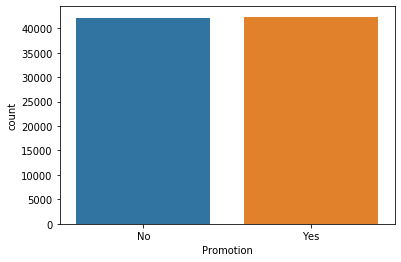

In [10]:
# check A/B groups 1:1 
sns.countplot(data=train_data, x='Promotion');

Customers are approximately equally divided into the treatment and control groups.

In [11]:
# check puchase rate in train_data
train_data['purchase'].mean()

0.012302742091939338

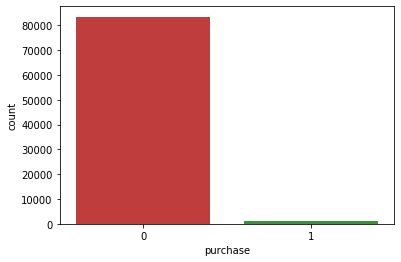

In [12]:
purch_palette = [sns.color_palette()[3], sns.color_palette()[2]]
sns.countplot(data=train_data, x='purchase', palette=purch_palette);

In [13]:
features = train_data.columns[3:].tolist()
features_df = train_data[features]
features_df.describe()

,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


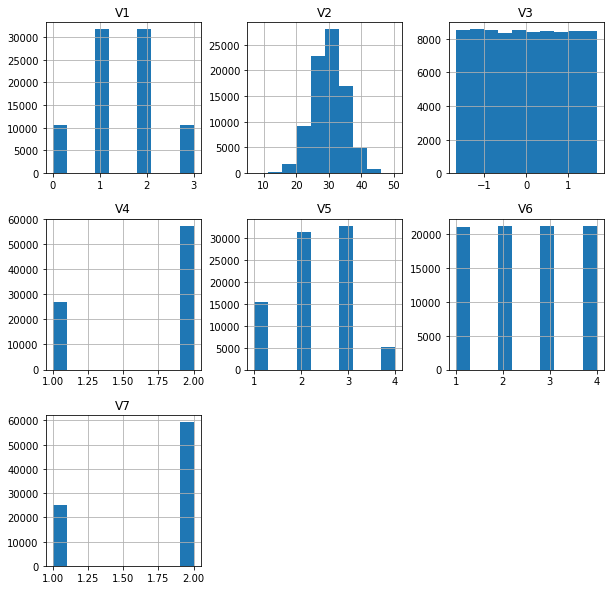

In [14]:
features_df.hist(figsize=(10,10));

'V2' 'V3' 数据具有连续性，所以为数值数据（'quantitative data'）， 'V1' 'V4' 'V5' 'V6' 'V7'呈现为分类数据特征 （'categorical data'）

### 2. 构建模型 1

建立模型的目的是发掘数据中隐藏的信息，找到有可能收到促销活动而进行有效购买的消费者，以提高促销的有效性，增加收入和减少促销成本。 在数据中建立 Y lable，当消费者收到促销优惠并进行有效购买时该值设置为1，否则为0.

In [15]:
train_data['y'] = np.where((train_data['purchase'] == 1)&(train_data['Promotion'] == 'Yes'), 1, 0)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,y
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0


In [16]:
dummied_df = pd.get_dummies(train_data, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
dummied_df.head()

,ID,Promotion,purchase,V2,V3,y,V1_0,V1_1,V1_2,V1_3,...,V5_1,V5_2,V5_3,V5_4,V6_1,V6_2,V6_3,V6_4,V7_1,V7_2
0,1,No,0,30.443518,-1.165083,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
1,3,No,0,32.159350,-0.645617,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2,4,No,0,30.431659,0.133583,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
3,5,No,0,26.588914,-0.212728,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,8,Yes,0,28.044332,-0.385883,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1


In [17]:
dummied_features = ['V2', 'V3',
                       'V1_0', 'V1_1', 'V1_2',
                       'V1_3', 
                       'V4_1', 'V4_2', 
                       'V5_1', 'V5_2', 'V5_3', 'V5_4',
                       'V6_1', 'V6_2','V6_3', 'V6_4', 
                       'V7_1', 'V7_2']

In [18]:
features = train_data.columns[3:-1]
X_train, X_test, Y_train, Y_test = train_test_split(dummied_df[dummied_features],dummied_df['y'],\
                                                    test_size= 0.25, random_state=45)

In [19]:
# Upsampling with ADASYN
X_train_ups, y_train_ups = ADASYN(sampling_strategy='minority', random_state=45).fit_sample(X_train, Y_train)

In [20]:
clf = MLPClassifier(solver='adam', activation='logistic',alpha=1e-4,hidden_layer_sizes=(50,50,50), \
                    random_state=45,max_iter=10000,verbose=10,tol=0.000000000001)

clf.fit(X_train_ups, y_train_ups)

Iteration 1, loss = 0.44712398
Iteration 2, loss = 0.23461936
Iteration 3, loss = 0.22035387
Iteration 4, loss = 0.21403352
Iteration 5, loss = 0.21041626
Iteration 6, loss = 0.20933575
Iteration 7, loss = 0.20720246
Iteration 8, loss = 0.20639750
Iteration 9, loss = 0.20421529
Iteration 10, loss = 0.20344574
Iteration 11, loss = 0.20210040
Iteration 12, loss = 0.20171010
Iteration 13, loss = 0.20106767
Iteration 14, loss = 0.20162374
Iteration 15, loss = 0.19929634
Iteration 16, loss = 0.19922164
Iteration 17, loss = 0.19769156
Iteration 18, loss = 0.19653855
Iteration 19, loss = 0.19607409
Iteration 20, loss = 0.19571607
Iteration 21, loss = 0.19494048
Iteration 22, loss = 0.19366421
Iteration 23, loss = 0.19348787
Iteration 24, loss = 0.19455613
Iteration 25, loss = 0.19202933
Iteration 26, loss = 0.19039113
Iteration 27, loss = 0.19044558
Iteration 28, loss = 0.19193579
Iteration 29, loss = 0.18997545
Iteration 30, loss = 0.18935316
Iteration 31, loss = 0.18819867
Iteration 32, los

Iteration 253, loss = 0.13676643
Iteration 254, loss = 0.13697508
Iteration 255, loss = 0.13715731
Iteration 256, loss = 0.13805063
Iteration 257, loss = 0.13664407
Iteration 258, loss = 0.13671273
Iteration 259, loss = 0.13744511
Iteration 260, loss = 0.13799086
Iteration 261, loss = 0.13568944
Iteration 262, loss = 0.13684469
Iteration 263, loss = 0.13601538
Iteration 264, loss = 0.13618551
Iteration 265, loss = 0.13589767
Iteration 266, loss = 0.13501673
Iteration 267, loss = 0.13628233
Iteration 268, loss = 0.13588511
Iteration 269, loss = 0.13582044
Iteration 270, loss = 0.13579574
Iteration 271, loss = 0.13540313
Iteration 272, loss = 0.13570344
Iteration 273, loss = 0.13560741
Iteration 274, loss = 0.13507522
Iteration 275, loss = 0.13549375
Iteration 276, loss = 0.13452090
Iteration 277, loss = 0.13522118
Iteration 278, loss = 0.13521318
Iteration 279, loss = 0.13444863
Iteration 280, loss = 0.13520290
Iteration 281, loss = 0.13600711
Iteration 282, loss = 0.13482639
Iteration 

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50, 50),
              max_iter=10000, random_state=45, tol=1e-12, verbose=10)

In [21]:
Y_pred = clf.predict(X_test)

In [22]:
accuracy_score(Y_test, Y_pred)

0.9460111668401627

In [23]:
cm = confusion_matrix(Y_test, Y_pred)
cm

array([[19976,   984],
       [  157,    17]])

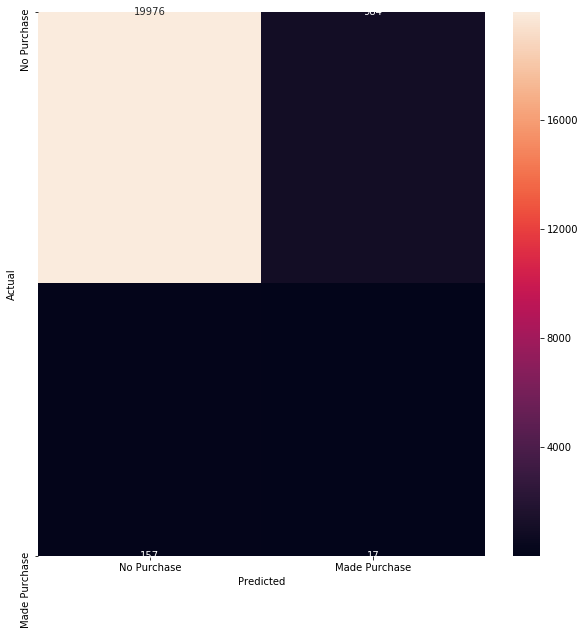

In [24]:
fig, ax= plt.subplots(figsize=(10,10))

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g', ax = ax)
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);
plt.show()

In [25]:
clf.coefs_

[array([[ 4.64974805e-01,  2.46435803e-01, -5.36202191e-02,
          1.57316517e-01, -6.24092761e-02, -4.66195429e-02,
         -5.51813809e-02,  6.10826765e-02, -9.33137361e-02,
         -1.84193377e-01, -3.10313260e-01, -3.99558811e-03,
          4.79621641e-02, -3.98719616e-01, -1.13672096e-02,
         -1.28365594e-01,  3.42287599e-01, -3.03068522e-02,
         -1.97817404e-01, -1.67442698e-02, -2.10712905e-02,
         -4.85434424e-02,  4.57314542e-02, -6.04190698e-02,
         -1.03805869e-01,  2.68111032e-01, -6.53127116e-02,
         -1.13596244e-01, -1.34995758e-01, -9.31759548e-02,
         -5.17787236e-03, -3.05544233e-02, -1.01521819e-01,
          2.47792209e-02, -2.93561595e-01,  5.10680678e-02,
         -3.03564430e-01, -1.52237622e-01, -3.11927539e-02,
          2.14239877e-01, -4.12885758e-01,  2.02011371e-02,
          2.02668968e-01, -3.44328911e-01,  1.06916561e-02,
         -1.28603809e-01, -1.34297419e-01,  2.06659199e-01,
         -4.82986442e-01, -2.43323017e-0

In [26]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    dummied_df = pd.get_dummies(df, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
    dummied_features = ['V2', 'V3',
                       'V1_0', 'V1_1', 'V1_2',
                       'V1_3', 
                       'V4_1', 'V4_2', 
                       'V5_1', 'V5_2', 'V5_3', 'V5_4',
                       'V6_1', 'V6_2','V6_3', 'V6_4', 
                       'V7_1', 'V7_2']
    
    dummied_df = dummied_df[dummied_features]
    
    preds =  clf.predict(dummied_df)
    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')

        else:
            promotion.append('No')
    promotion = np.array(promotion)
    
    return promotion    

In [27]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0189.

Your nir with this strategy is 38.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018902081274703556, 38.20000000000002)

### 3. 构建模型 2

In [28]:
train_data['response'] = train_data.apply(lambda row: 1 if (row['purchase'] == 1) and (row['Promotion']=='Yes') else 0, axis=1, result_type='expand')

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data[features], train_data['response'], test_size=0.2, random_state=45)

In [30]:
# Upsampling with ADASYN
X_train_ups, y_train_ups = ADASYN(sampling_strategy='minority', random_state=45).fit_sample(X_train, y_train)

In [31]:
X_train_ups = pd.DataFrame(X_train_ups, columns=features)
eval_set = [(X_train_ups, y_train_ups), (X_valid, y_valid)]

In [32]:
model = XGBClassifier(learning_rate=0.1, objective = 'binary:logistic')
model.fit(X_train_ups, y_train_ups, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=30, verbose=False)
y_pred = model.predict(X_valid , ntree_limit=model.best_ntree_limit)

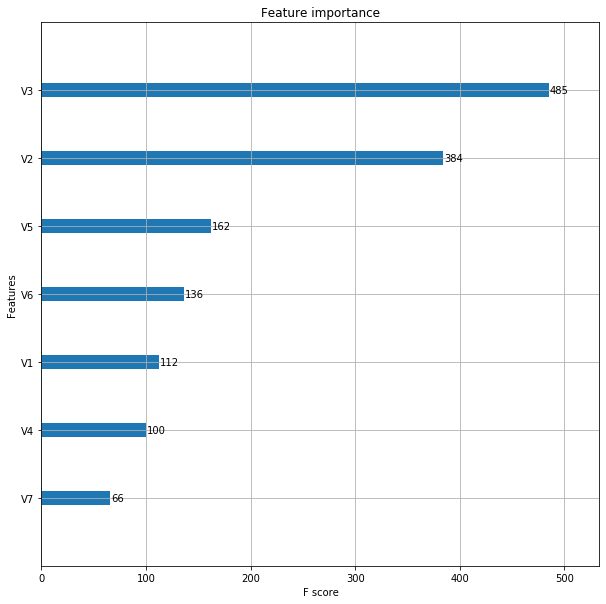

In [33]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_importance(model, ax=ax);

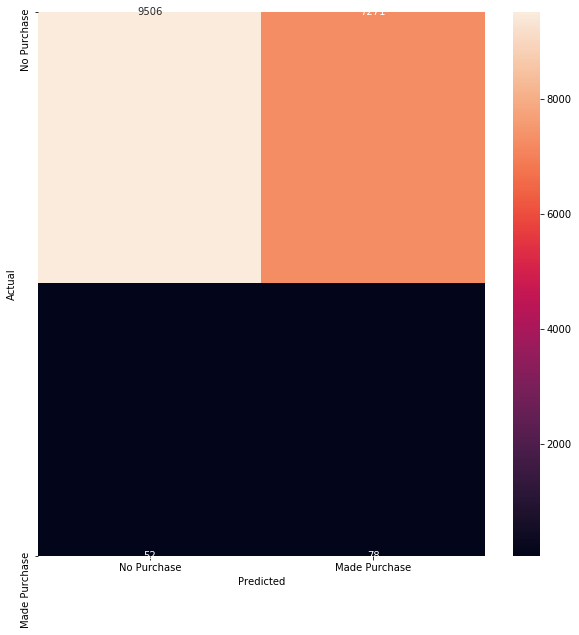

In [34]:
fig, ax= plt.subplots(figsize=(10,10))

confusion_matrix = pd.crosstab(y_valid, y_pred, rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g', ax = ax)
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);
plt.show()

In [35]:
def promotion_strategy(df):

    result = []
    
    preds = model.predict(df)
    
    for pred in preds:
        if pred == 1:
            result.append('Yes')
        else:
            result.append('No')

        
    result = np.array(result)
    
    return result

In [36]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0163.

Your nir with this strategy is 103.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.016250088619233865, 103.25)